# FACIAL KEYPOINTS DETECTION

**Importing the libraraies**

In [23]:
import numpy as np
import pandas as pd
import math
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import optimizers
from IPython.display import clear_output
pd.options.mode.chained_assignment = None  # default='warn'


**Building a Client for  Kaggle API**

Follow the instructions in https://github.com/Kaggle/kaggle-api to download Kaggle.json file


In [24]:
os.environ['KAGGLE_USERNAME'] = "mariaafara" # username from the json file
os.environ['KAGGLE_KEY'] = "25755ae03c0b83042774e5e0d15b886e" # key from the json file

In [25]:
#Crearting a Client to host the Kaggle API
!pip install -q kaggle

In [26]:
# Improting the dataet using Kaggle API provided for the Facial Keypoint Detection
!kaggle competitions download -c facial-keypoints-detection

facial-keypoints-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [27]:
!unzip facial-keypoints-detection.zip -d facial-keypoints-detection

Archive:  facial-keypoints-detection.zip
replace facial-keypoints-detection/IdLookupTable.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [28]:
!ls

data			       FacialKeyPointsDetection.ipynb
facial-keypoints-detection     facial-keypoints-detection.zip
FacialKeyPointsDetection.html


## PART 1 - Dataset Preparation

### Part 1.1 EDA and Feature Engineering
This is the data analaysis of our dataset whilist descovering the missing values, train a model for each feature to use it to replace the missing features.


###### **Importing the Data Frames using Pandas**

In [30]:
train_data = pd.read_csv('facial-keypoints-detection/training.zip', compression='zip', header=0, sep=',', quotechar='"')
# test_data = pd.read_csv('test.zip', compression='zip', header=0, sep=',', quotechar='"')
# lookid_data = pd.read_csv('IdLookupTable.csv',header=0, sep=',', quotechar='"')

In [31]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


###### **Transform image string into 2D array**
Since values for the image is given as space separated string, we will need to separate the values using ' ' as separator<br>
Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96,96)

In [32]:
# transform
train_data['Image'] = train_data['Image'].apply(lambda x: np.fromstring(x, dtype= int, sep = ' ').reshape(96,96))

In [33]:
# train_data['Image'] = train_data['Image'].apply(lambda x: list(map(float, x.strip().split(" "))))

In [34]:
# Let's obtain the shape of the resized image
train_data['Image'][1].shape

(96, 96)

##### **Visualize some images with face landmarks**

In [107]:
def visualize_random_image(df,i=-1):
    """
    Method that visualize a certain image with index i in the df or a random image with i=-1.
    With plotting the facial keypoints specified in the df cols
    """
    # x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
    if i==-1:
        i = np.random.randint(1, len(df))
        plt.figure()
        plt.imshow(df['Image'][i],cmap='gray')
        nbr_cols = df.columns.tolist()[:-1]
        for j in range(0,len(nbr_cols),2):
            plt.plot(df.loc[i][j], train_data.loc[i][j+1], 'rx')
    plt.savefig("face2.png")

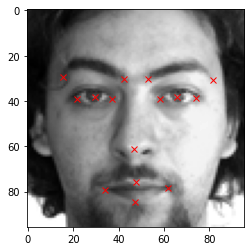

In [108]:
visualize_random_image(train_data, i=-1)

##### **Checking for missing values**

In [37]:
# checking for missing values
train_data.isnull().any().value_counts()

True     28
False     3
dtype: int64

So there are missing values in 28 columns. Lets see which columns

In [38]:
display(train_data.isnull().sum())

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

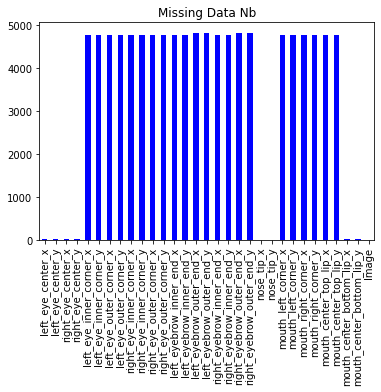

In [126]:
train_data.isnull().sum().plot(kind='bar',color = 'blue')
plt.title("Missing Data Nb")
# plt.tight_layout()
plt.savefig("images/missing_data_nb.png", bbox_inches = "tight")
plt.show()

In [40]:
# count the number of rows with missing values
train_data.isnull().any(axis=1).sum() 

4909

The number of data is 7049 and 4909 rows are with missing values which means more than the half. Thus we cannot drop them.

**Visualize how many missing values per rows**

In [41]:
df_missing = train_data[train_data.isnull().any(axis=1)]
df_missing.shape

(4909, 31)

In [42]:
df_missing["missing_values_count"] = df_missing.isnull().sum(axis=1)

In [43]:
df_missing.groupby(["missing_values_count"])[["Image"]].count()

,Image
missing_values_count,
2,87
4,28
6,9
8,8
10,3
12,5
14,2
20,2
22,4755


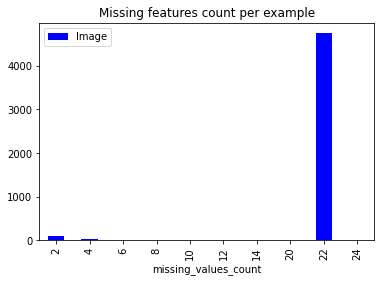

In [121]:
fig = df_missing.groupby(["missing_values_count"])[["Image"]].count().plot(kind='bar',color = 'blue', title="Missing features count per example").get_figure()
fig.savefig("images/missing_features_count.png")

#### **Dealing with missing values**


**Prepare datasets to train a model for each feature inorder to use it to replace the missing values**

Inorder to fill the missing values, we will train a prediction model for each feature except the nose as it doesn't have any missing value. Thus we shall train 14 model. First we will prepare the dataset for each feature.
<br> We will build a dictionary of dataframes that contain the dataset for each feature (separating features from each other)

In [45]:
dic_train_data={}
dic_missing_data={}

dic_train_data_size={}
cols = train_data.columns.tolist()[:30]
# to take out the nose feature
cols.remove('nose_tip_x')
cols.remove('nose_tip_y')

for col_i in range(0,len(cols),2):
  # constructing the features
    feature_name = cols[col_i][:-2]
    feature = [cols[col_i],cols[col_i+1],"Image"]
    # get all rows that does not contain a missing value for the specified feature
    feature_df = train_data[feature]
    df_feature_not_missing = feature_df[~feature_df.isnull().any(axis=1)]
    df_feature_missing = feature_df[feature_df.isnull().any(axis=1)]
    dic_train_data_size[feature_name]=df_feature_not_missing.shape[0]
    dic_train_data[feature_name]=df_feature_not_missing
    dic_missing_data[feature_name]=df_feature_missing

Lets see the number of non null examples for each feature pf the 14 feature.<br>This will be the size of the dataset that we will remain with for each feature.

In [55]:
dic_train_data_size

{'left_eye_center': 7039,
 'right_eye_center': 7036,
 'left_eye_inner_corner': 2271,
 'left_eye_outer_corner': 2267,
 'right_eye_inner_corner': 2268,
 'right_eye_outer_corner': 2268,
 'left_eyebrow_inner_end': 2270,
 'left_eyebrow_outer_end': 2225,
 'right_eyebrow_inner_end': 2270,
 'right_eyebrow_outer_end': 2236,
 'mouth_left_corner': 2269,
 'mouth_right_corner': 2270,
 'mouth_center_top_lip': 2275,
 'mouth_center_bottom_lip': 7016}

In [48]:
# view an example
dic_train_data["right_eyebrow_outer_end"].head()

,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,Image
0,16.356379,29.647471,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,..."
1,16.865362,27.058860,"[[219, 215, 204, 196, 204, 211, 212, 200, 180,..."
2,16.791158,32.087116,"[[144, 142, 159, 180, 188, 188, 184, 180, 167,..."
3,20.458017,29.909343,"[[193, 192, 193, 194, 194, 194, 193, 192, 168,..."
4,15.925870,30.672177,"[[147, 148, 160, 196, 215, 214, 216, 217, 219,..."


In [51]:
import pickle as pkl
pkl.dump(dic_train_data, open("data/dic_train_data.pkl","wb"))
pkl.dump(dic_train_data_size, open("data/dic_train_data_size.pkl","wb"))
pkl.dump(dic_missing_data, open("data/dic_missing_data.pkl","wb"))

save the dictionaries in pickle format

### Part 1.2 **Create custom Data Generator**

**We will build a data generator that will load mini-batches and feed to the model dynamically**

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, rgb_channels=True, shuffle=True, augment=True, normalize_image=True, normalize_coordinates=False, scalers=None):
        self.df = df
        self.batch_size = batch_size
        self.size = df.shape[0]
        self.shuffle = shuffle
        self.augment = augment
        # Keras pre-trained models have trained on color images and if we want to use grayscale images we can still use these pre-trained models by repeating the grayscale image over three channels
        self.rgb_channels = rgb_channels
        self.normalize_image = normalize_image
        self.normalize_coordinates = normalize_coordinates
        self.scalers = scalers
        self.feature_columns = df.columns.tolist()[:-1]
        #  To keep track on which pairs of landmarks to be swapped, we introduce a dictionary recording the original and new landmark's index
        self.left_right_dic = {'right_eye_center_x' : 'left_eye_center_x' ,
                'right_eye_center_y' : 'left_eye_center_y' ,
                'right_eye_inner_corner_x' : 'left_eye_inner_corner_x' ,
                'right_eye_inner_corner_y' : 'left_eye_inner_corner_y' ,
                'right_eye_outer_corner_x' : 'left_eye_outer_corner_x' ,
                'right_eye_outer_corner_y' : 'left_eye_outer_corner_y' ,
                'right_eyebrow_inner_end_x' : 'left_eyebrow_inner_end_x' ,
                'right_eyebrow_inner_end_y' : 'left_eyebrow_inner_end_y' ,
                'right_eyebrow_outer_end_x' : 'left_eyebrow_outer_end_x' ,
                'right_eyebrow_outer_end_y' : 'left_eyebrow_outer_end_y' ,
                'mouth_right_corner_x' : 'mouth_left_corner_x' ,
                'mouth_right_corner_y' : 'mouth_left_corner_y' }
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.size // self.batch_size

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.size)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # selects indices of data for next batch`
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        'Generate one batch of data'
        batched_df = self.df.iloc[indexes] #.sample(frac=1).reset_index(drop=True)

        if self.augment == True:
            df_batch = self.augmentor(batched_df)
        else:
            df_batch = batched_df


        batched_images = np.vstack(df_batch["Image"].values).reshape(-1, 96, 96, 1).astype(np.float32)
        
        if self.rgb_channels:
            batched_images = np.repeat(batched_images,3,-1)

        batched_feature_corrdinates = df_batch.iloc[:,:-1]
        
        if self.normalize_coordinates:
            for col in self.feature_columns:
                scaler = self.scalers[col]
                batched_feature_corrdinates[col] = scaler.transform(batched_feature_corrdinates[col].to_numpy().reshape(-1, 1)).reshape(-1)

        batched_feature_corrdinates = batched_feature_corrdinates.values.astype(np.float32) #feature coordinates        

        if self.normalize_image == True:
            batched_images = batched_images/255

        return batched_images, batched_feature_corrdinates

    def augmentor(self, df):

        def flip_horizontally(row):
            'Method that flips the image horizontally and swaps the features' 
            row["Image"] = np.flip(row["Image"], axis = 1)
            # y coordinates values will stay the same while the x coordinates will have to be changed
            # subtract our initial x-coordinate values from width of the image(96)
            for i in range(len(self.feature_columns)):#+1
                if i%2 == 0: # because there is always x coordinate then y corrdinate
                    row[self.feature_columns[i]] = 96. - row[self.feature_columns[i]]
            # swap
            rights = [a for a in self.feature_columns if "right" in a.split("_")]
            for col_r in rights:
                col_l = self.left_right_dic[col_r]
                temp = row[col_l] 
                row[col_l] = row[col_r]
                row[col_r] = temp
            return row

        def increase_brightness(image):
            'Method that randomly increase images brightness'      
            # Multiply pixel values by random values between 1 and 1.5 to increase the brightness of the image
            # Clip the value between 0 and 255
            image = np.clip(random.uniform(1, 1.5) * image, 0.0, 255.0)
            return image

        def decrease_brightness(image):
            'Method that randomly decrease images brightness'
            # Multiply pixel values by random values between 0 and 0.1 to decrease the brightness of the image
            # Clip the value between 0 and 255
            image = np.clip(random.uniform(0, 0.1) * image, 0.0, 255.0)
            return image

        def augment(row):
        # if we have more than one feature allow flipping
            if len(self.feature_columns)>2:
                if row["augment_flip"]==1:
                    row =  flip_horizontally(row)
            if row["augment_inc_b"]:
                row["Image"] = increase_brightness(row["Image"])
            if row["augment_dec_b"]:
                row["Image"] = decrease_brightness(row["Image"])
            return row

      # generate random boolean for augmentation types 
        df["augment_flip"] = [random.getrandbits(1) for i in range(len(df))]
        df["augment_inc_b"] = [random.getrandbits(1) for i in range(len(df))]
        df["augment_dec_b"] = [random.getrandbits(1) for i in range(len(df))]
        # df = df.apply(lambda row : augment(row), axis=1)
        df = df.apply(augment, axis=1)
        df.drop(['augment_flip', 'augment_inc_b', 'augment_dec_b'], axis=1, inplace=True)
        return df


In [ ]:
def visualize_image(x, y):
  # x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
    plt.figure()
    plt.imshow(x, cmap='gray')
    f = y.shape[0]
    for j in range(0,f,2):
        plt.plot(y[j], y[j+1], 'rx') 'rx')

Lets try the data generator and visuilize some images

In [ ]:
# build scalers for each feature to use it for their normalization
scalers_dict = dict()
for col in train_data.columns.tolist()[:-1]         scaler = MinMaxScaler       
  scaler.fit(train_data[col].to_numpy().reshape(-1,        
  scalers_dict[col] = scaler

In [ ]:
scalers_dict["right_eye_center_x"]

MinMaxScaler(copy=True, feature_range=(0, 1))

trying out the generator

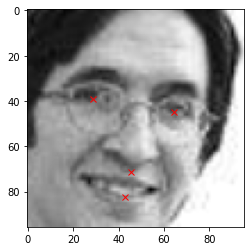

In [ ]:
gen = DataGenerator(train_data, batch_size = 32, augment=True, normalize_image=False, normalize_coordinates=False, scalers=scalers_dict)
# df = dic_train_data["right_eyebrow_outer_end"]
item_index = 3
element_index = 4
batch = gen.__getitem__(item_index)
image  = batch[0][element_index].reshape(96,96,3)[:,:,0]
coordinates = batch[1][element_index]
visualize_image(image, coordinates)